In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm

assert torch.cuda.is_available()

In [103]:
class MyLinearModel(nn.Module):
  # We'll include nn.Linear as a good, easy starting point
  
  def __init__(self, dataset):
    """
    A fully-connected linear layer that takes m inputs and returns n outputs.
    """
    super().__init__()
    x, y = dataset[0]
    c, h, w = x.size() # (1, 28, 28)
    out = y.size(0)
    
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # (32, 28, 28)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # (64, 28, 28)
    self.pool2 = nn.MaxPool2d(2) # (64, 14, 14)
    self.conv3 = nn.Conv2d(64, 64, kernel_size=3) # (64, 12, 12)
    self.pool3 = nn.MaxPool2d(2) # (32, 6, 6)
    self.fc1 = nn.Linear(64*6*6, 128) # (128,)
    self.fc2 = nn.Linear(128, 10) # (10,)
    
  def forward(self, x):
    n, c, h, w = x.size()
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x)
    n, c, h, w = x.size()
    x = x.view(n, c*h*w)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x
  

class FashionDataset(Dataset):
  # Includes the FashionMNIST dataset.
  
  def __init__(self, train=True):
    super().__init__()
    transform = transforms.Compose([transforms.ToTensor()])
    self.train = train
    self.dataset = datasets.FashionMNIST(root="", 
                                         train=train, 
                                         download=True,
                                         transform=transform, 
                                         target_transform=None)
    
  def __getitem__(self, key):
    images, labels = self.dataset[key]
    return images, torch.eye(10)[labels]
  
  def __len__(self):
    if self.train:
      return len(self.dataset)
    else:
      return 256*4 # len(self.dataset)   

In [110]:
train_dataset = FashionDataset(train=True)
test_dataset = FashionDataset(train=False)
model = MyLinearModel(train_dataset)
model = model.cuda() # moves the model to the GPU
objective = torch.nn.CrossEntropyLoss() # includes the softmax in itself, so don't double up in the net.
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.005)
train_loader = DataLoader(dataset=train_dataset, 
                    batch_size=256, 
                    pin_memory=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=256,
                         pin_memory=True)

training_losses = []
validation_losses = []
training_accuracy = []
validation_accuracy = []

num_epochs = 20
loop = tqdm(total=num_epochs*len(train_loader), position=0)

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        x, y_truth = data
        x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)

        optimizer.zero_grad()

        y_hat = model(x)
        loss = objective(y_hat, y_truth.argmax(dim=1))
        acc = torch.mean((y_hat.argmax(dim=1) == y_truth.argmax(dim=1)).float())

        training_losses.append(loss)

        loop.set_description("loss: {:.3f}, acc: {:.3f}".format(loss.item(), acc.item()))
        loop.update(1)

        loss.backward()

        optimizer.step()

        if i%235 == 0:
            training_accuracy.append(acc)
            validation_accuracy.append(np.mean([
                torch.mean((model(x.cuda()).argmax(dim=1) == y_truth.cuda().argmax(dim=1)).float()).item()
                for x, y_truth in test_loader
            ]))
        
        
    
loop.close()
print("Done")

loss: 0.265, acc: 0.927: 100%|██████████| 4700/4700 [02:21<00:00, 33.17it/s]

Done


In [72]:
len(train_loader)

235

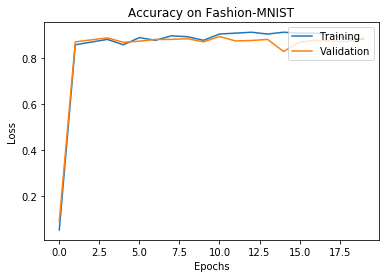

Training Acc: 0.8828125
Validation Acc: 0.8896484375


In [111]:
def display_error(training_loss, validation_loss, training_timesteps=235, validation_timesteps=235):
    """
    Parameters:
    training_error ((N,) ndarray): the training error per iteration.
    validation_error ((N,) ndarray): the validation error per iteration.
    """
    xs = np.arange(len(training_loss))
#     xs = training_timesteps*np.arange(len(training_loss))
    plt.plot(xs, training_loss, label="Training")
#     xs = validation_timesteps*np.arange(len(validation_loss))
    plt.plot(xs, validation_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Accuracy on Fashion-MNIST")
    plt.legend(loc='upper right')
    plt.show()
  
display_error(training_accuracy, validation_accuracy)
print("Training Acc:", training_accuracy[-1].item())
print("Validation Acc:", validation_accuracy[-1])